In [1]:
import sys, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack, vstack
import pywt
import h5py
sys.path.insert(1, '/home/luiz/IC/Codes/GMCA/gmca4im-master/scripts/')
import gmca4im_lib2 as g4i
from scipy import signal
from sklearn.decomposition import FastICA, PCA
import Extension4BINGO as cs

In [2]:
######## Funções adicionais
######################################################################################################
######## Função para colocar média 0 nos mapas, retorna uma variavel igual ao input
def Remove_mean(map_= None):
    len_nu_ch = np.shape(map_)[0]
    map_ = np.array([[map_[i] - np.mean(map_[i],axis=0)] for i in range(len_nu_ch)])
    return map_[ : , 0, : ]
######################################################################################################

######################################################################################################
####### Tangente hiperbolica como funcão parâmetro G que aproxima a neg-entropy, retorna W
def tanh(x):
    return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
######################################################################################################

######################################################################################################
######## Faz a penrose moore inverse com a matriz mistura e os mapas X
def Filter(Ae=None, FG=False):
    W   = np.linalg.inv(np.dot(Ae.T,Ae))
    W   = np.dot(W,Ae.T) #Filter  
    if FG:
        return np.dot(Ae,W) #foreground filter
    else:
        return W
######################################################################################################

######################################################################################################
######## Constroi uma variavel que recebe um mapa e a matriz mistura A, e retorna os mapas separados em 21 e fg
def Reconstruction_maps(X=None,Ae=None):
    X_fg = np.dot(Filter(Ae=Ae,FG=True),X)
    X_21 = X - X_fg
    return {"21cm":X_21,"foregrounds":X_fg}
######################################################################################################

######################################################################################################
######## Constroi uma função que retorna os residos separados em 21 e fg
def Residual_maps(X=None,Ae=None):
    X    = Reconstruction_maps(X,Ae)
    W_fg = Filter(Ae,True)
    R_21 = X["21cm"]        - np.dot(W_fg,X["21cm"])  
    R_fg = X["foregrounds"] - np.dot(W_fg,X["foregrounds"])  
    return {"21cm":R_21, "foregrounds":R_fg}
######################################################################################################

######################################################################################################
########
def Include_scalar_coefs(w,c,J=3):
    nbins,npix = c.shape

    for i in range(nbins):
        X = w[i].reshape(-1,J).T
        X = np.vstack((X,c[i]))
        X = X.T.flatten()
        if i==0:
            Xw_ = np.array(X)
        else:
            Xw_ = np.vstack((Xw_,X))
    return Xw_
######################################################################################################

/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_

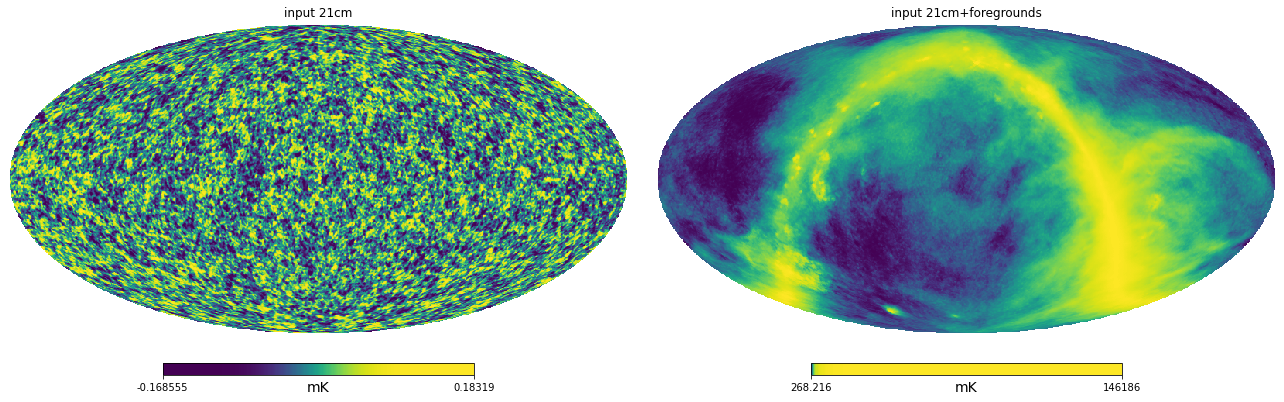

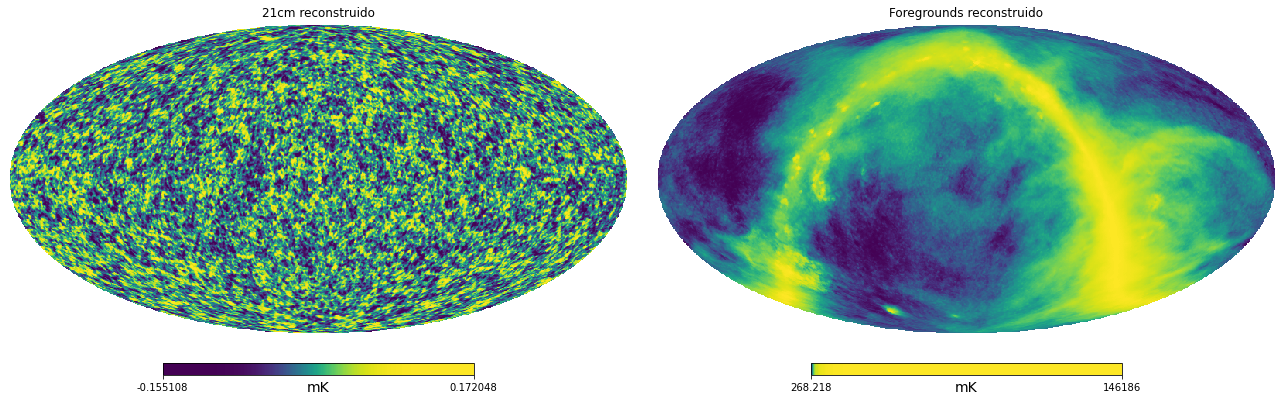

In [3]:
######## fastICA sem wavelets
NSIDE = 2**8
######################################################################################################
######## Leitura dos arquivos
file_21cm = '/home/luiz/IC/Datas_Maps/Cube_21_L100_Smooth.fits' #Arquivo só com 21cm
with fits.open(file_21cm) as hdul1: 
    input_21cm = hdul1[0].data

file_mapas ='/home/luiz/IC/Datas_Maps/Cube_5PSM_L100_RS.fits' #Arquivo com tudo, foregrounds+21cm
with fits.open(file_mapas) as hdul2: 
    X = hdul2[0].data
######################################################################################################

######################################################################################################
######## Algoritmo fastICA para obter a matriz mistura aproximada
ica = FastICA(n_components=5)
Se = ica.fit_transform(X.T)  # Reconstruct signals
Ae = ica.mixing_  # Get estimated mixing matrix
######## Obtém os mapas separados em 21cm e foregrounds no dicionario X_rec
X_rec = Reconstruction_maps(X, Ae)
######################################################################################################

######################################################################################################
######## Visualização dos mapas
plot = [input_21cm[13], X[13], X_rec['21cm'][13], X_rec['foregrounds'][13]] #vetor com os mapas
title = ["input 21cm", "input 21cm+foregrounds", "21cm reconstruido", "Foregrounds reconstruido"] #vetor com os nomes
plt.figure(figsize = (18,8))
for i in range(2):
        hp.mollview(plot[i], sub=(1,2,i+1), norm='hist', title=title[i], unit='mK' )
plt.figure(figsize = (18,8))
for i in range(2):
        hp.mollview(plot[i+2], sub=(1,2,i+1), norm='hist', title=title[i+2], unit='mK' )
######################################################################################################

variância (rec-input):          0.0001216878260010821
desvio padrao (rec-input):          0.011031220512757511


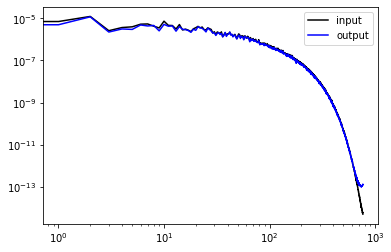

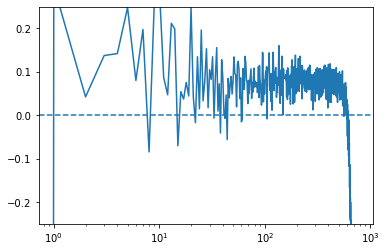

In [4]:
######## Verificação do erro da reconstrução
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(X_rec['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var((X_rec['21cm'][13])-input_21cm[13]))
print('desvio padrao (rec-input):         ',np.std((X_rec['21cm'][13])-input_21cm[13]))
######################################################################################################

In [5]:
######## Mudando alguns parametros da função FastICA()
######################################################################################################
######## Algoritmo fastICA para obter a matriz mistura aproximada
ica = FastICA(n_components=5, max_iter=1000, tol=1e-7, fun=tanh) ######### Mudei aqui!
Se = ica.fit_transform(X.T)  # Reconstruct signals
Ae = ica.mixing_  # Get estimated mixing matrix
######## Obtém os mapas separados em 21cm e foregrounds no dicionario X_rec
X_rec = Reconstruction_maps(X, Ae)
######################################################################################################

/home/luiz/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [6]:
######## Verificação do erro da reconstrução
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(X_rec['21cm'][13])
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var((X_rec['21cm'][13])-input_21cm[13]))
print('100*variância (rec-input)/input:         ',100*np.var(X_rec['21cm'][13]- input_21cm[13]/(input_21cm[13])))
######################################################################################################

######### MUDAR OS PARAMETROS DA FUNÇAO FastICA() NAO AJUDA EM QUASE NADA...

variância (rec-input):          0.0001216868706692071
100*variância (rec-input)/input:          0.14734331710919513


In [7]:
######## Outros mapas

variância (rec-input):          0.0001968256615597561
variância (rec-input)/input:          0.10424096321153624


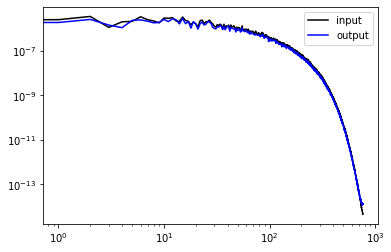

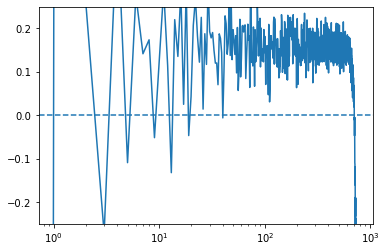

In [8]:
# MAPA 2
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[2])
cl_output = hp.anafast(X_rec['21cm'][2])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var((X_rec['21cm'][2])-input_21cm[2]))
print('variância (rec-input)/input:         ',100*np.var(X_rec['21cm'][2]- input_21cm[2]/(input_21cm[2])))
######################################################################################################

variância (rec-input):          0.002222323889436651
variância (rec-input)/input:          0.012686868976206746


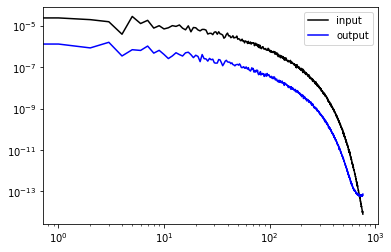

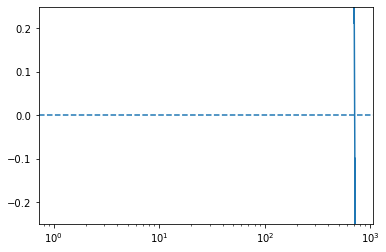

In [9]:
# MAPA 29
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[29])
cl_output = hp.anafast(X_rec['21cm'][29])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var((X_rec['21cm'][29])-input_21cm[29]))
print('variância (rec-input)/input:         ',100*np.var(X_rec['21cm'][29]- input_21cm[29]/(input_21cm[29])))
######################################################################################################

######## O ULTIMO MAPA SEMPRE TEM PROBLEMAS...